In [5]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [6]:
import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from scipy.stats.mstats import gmean

In [7]:
rf_rates = dl.pull('RFrates').divide(100)
daily_rf_rates = (rf_rates + 1).pow(1/261)-1
daily_rf_rates = daily_rf_rates.resample('B').ffill()

rf_rate_matrix = pd.DataFrame(0, index=bond_return_index.index, 
                              columns=bond_return_index.columns)
for country in country_codes:
    rf_rate_matrix[country] = daily_rf_rates


# Helper Functions

**Profit and Loss Curve Function**

In [77]:
def pnl_curve(signals):
    daily_signals = signals.resample("B").ffill()
    #long_signals = pd.DataFrame(1, index=daily_signals.index,
                               #columns=daily_signals.columns)
    
    bond_daily_returns = bond_return_index.pct_change() - rf_rate_matrix
    lagged_returns = bond_daily_returns.shift(-1)

    sig_returns = (lagged_returns * daily_signals)
    cum_sig_returns = (1+sig_returns).cumprod()
    sig_pct = (cum_sig_returns-1)*100
    
    #long_returns = (lagged_returns * long_signals)
    #cum_long_returns = (1+long_returns).cumprod()
    #long_pct = (cum_long_returns-1)*100
    
    for country in country_codes:
        sig_pct[country].dropna().rolling(60).mean().plot()
        #long_pct[country].plot()
        plt.title(country + ' Returns')
        plt.ylabel('Return Percentage')
        plt.show()
    
    sig_pct.sum(axis=1).plot()
    plt.title('Total Returns')
    plt.ylabel('Return Percentage')
    plt.show()

**Sharpe Ratio Function**

In [9]:
def sharpe_ratio(signals):
    
    daily_signals = signals.resample("B").ffill()
    
    bond_daily_returns = bond_return_index.pct_change() - rf_rate_matrix 
    lagged_returns = bond_daily_returns.shift(-1)

    returns = (lagged_returns * daily_signals) 
    
    country_SR = pd.Series(float(), index=country_codes)
    
    for country in country_codes:
        country_returns = returns[country].dropna()
        gmean_returns = gmean(1+country_returns)
        overall_return = (gmean_returns)**(261)-1
        overall_risk = country_returns.std()*np.sqrt(261)
        country_SR[country] = overall_return/overall_risk
    
    gmean_returns = gmean(1+returns.sum(axis=1))
    overall_return = (gmean_returns)**(261)-1
    overall_risk = returns.sum(axis=1).std()*np.sqrt(261)
    
    country_SR['OVERALL'] = (overall_return/overall_risk)
    
    return(country_SR)

**Plot Variables vs Bond Returns Function**

In [10]:
def plot_vs_returns(df, string, var_window=1):
    bond_return_index = dl.pull('BondRetIdx/LocalFX')
    bond_daily_returns = bond_return_index.pct_change()
    bond_monthly_returns = bond_daily_returns.resample('M').mean()
    bond_monthly_returns = bond_monthly_returns.shift(-1)
    
    for country in country_codes:
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.plot(df[country].to_timestamp().rolling(var_window).mean(), color='blue', 
                 label = string)
        ax2.plot(bond_monthly_returns[country].to_timestamp()
         .rolling(60).mean(),color='magenta', label = 'bond returns')
        plt.title(country + ' ' + string + ' vs. Bond Returns')

# Curve Height & Bond Premium Indicator

When using curve height as an indicator, it's most important to judge the different curve heights relative to other countries in a given year, since curve height is representative of international opportunity cost and will drive flows between different countries. Secondly, curve height should be measured based on its value relative to other countries, rather than its change over time. Our best indicator will tell us where a country's curve height lies relative to other countries, rather than whether it is increasing or decreasing, because its relative value is what will drive investors to buy or sell in different countries, causing prices to either rise or fall in the future.

To calculate our indicator, first, we'll calculate curve height as an average of long and short rates.

In [11]:
long_rates = dl.pull('LongRates')
short_rates = dl.pull('ShortRates')

curve_height = (long_rates+short_rates)/2
curve_height.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2020-04,0.4490,-0.5615,0.5040,0.2885,-0.2510,0.9795,-0.0635,-0.4605,0.2145,0.4345
2020-05,0.5590,-0.6725,0.4275,0.3120,-0.3555,1.1510,-0.0920,-0.5950,0.1415,0.4210
2020-06,0.5865,-0.5230,0.4090,0.0900,-0.2650,0.9060,-0.0780,-0.5710,0.1155,0.4100
2020-07,0.6020,-0.5300,0.4065,0.0090,-0.3270,0.7250,-0.0450,-0.5235,0.0750,0.4230
2020-08,0.5745,-0.6105,0.3655,-0.0185,-0.4105,0.5265,-0.0540,-0.6630,0.0130,0.3390


As discussed above, relative curve heights are important when determining opportunity cost between different countries. To relativize the curve heights in each year, I calculated a simple moving global average that incorporates values from the last five years and subtracted it from each value, to show how each country's curve height compared to the global average (in absolute terms). I then standardized within countries so that the mean and standard deviation within each country was 0 and 1, respectively.

In [12]:
global_avgs = curve_height.mean(axis=1)
CH_sma_5Y = global_avgs.rolling(60).mean()

relative_CH = curve_height.sub(CH_sma_5Y,axis=0)
standardized_CH = (relative_CH-relative_CH.mean())/relative_CH.std()
standardized_CH.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2020-04,-0.911156,0.150009,0.018706,-0.419740,-0.157544,-0.158720,1.638340,1.057515,-0.300431,0.336167
2020-05,-0.841569,0.068705,-0.041773,-0.394633,-0.253155,-0.047099,1.626729,0.931063,-0.364888,0.334103
2020-06,-0.818775,0.199794,-0.047694,-0.548331,-0.148505,-0.189728,1.643821,0.967930,-0.379326,0.334916
2020-07,-0.801222,0.206259,-0.036219,-0.596675,-0.196493,-0.291393,1.675272,1.031783,-0.405782,0.356244
2020-08,-0.809340,0.151824,-0.061613,-0.606991,-0.268006,-0.404727,1.678164,0.902896,-0.456129,0.302412


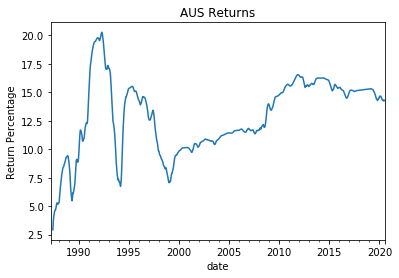

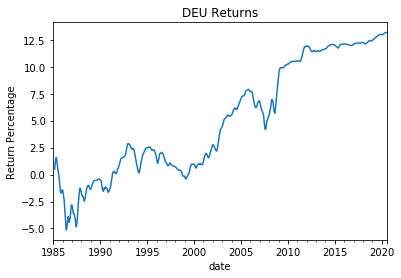

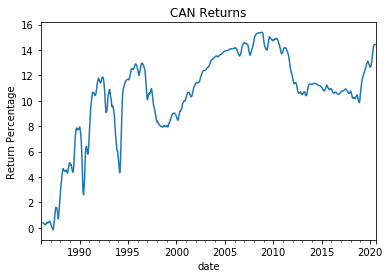

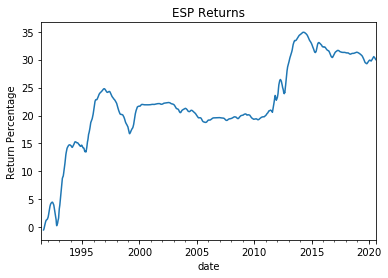

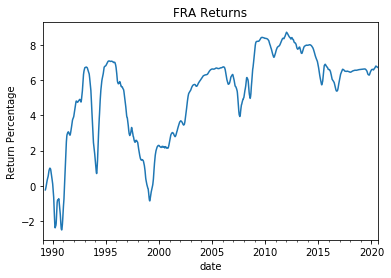

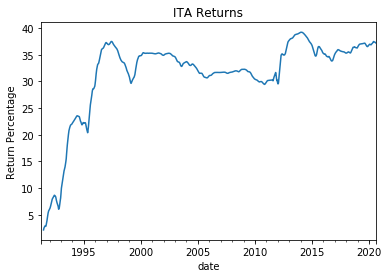

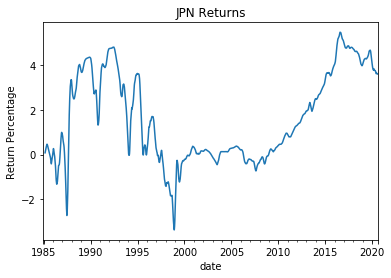

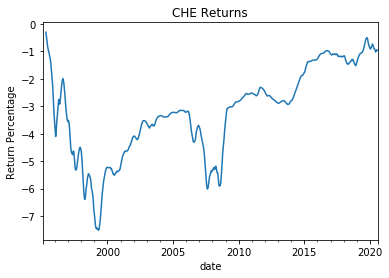

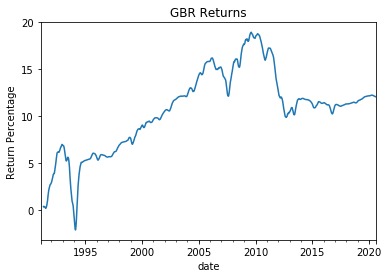

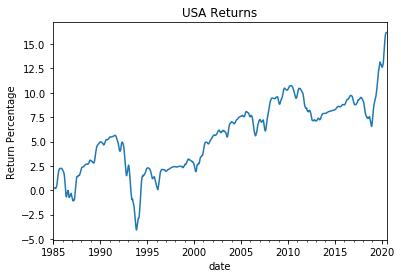

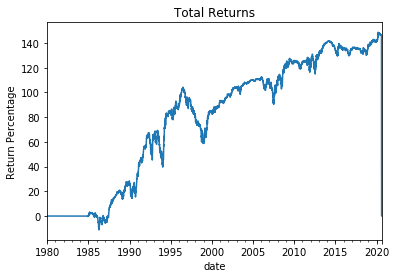

In [97]:
CH_signals = standardized_CH.divide(4).clip(-1,1)
pnl_curve(CH_signals)

In [98]:
sharpe_ratio(CH_signals)

country
AUS        0.207919
DEU        0.253720
CAN        0.205587
ESP        0.398350
FRA        0.141427
ITA        0.488024
JPN        0.079288
CHE       -0.026303
GBR        0.247164
USA        0.257524
OVERALL    0.473952
dtype: float64

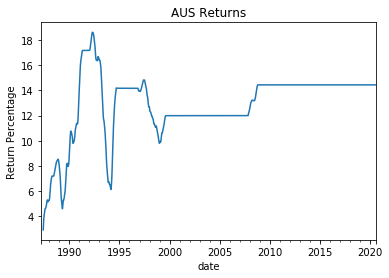

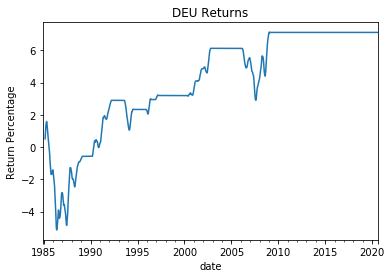

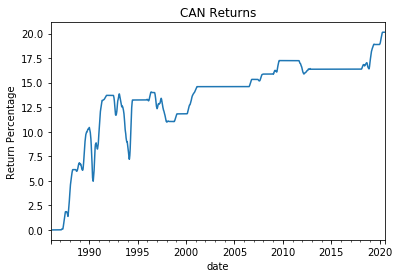

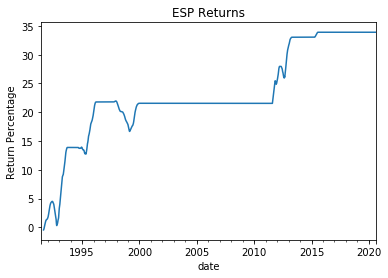

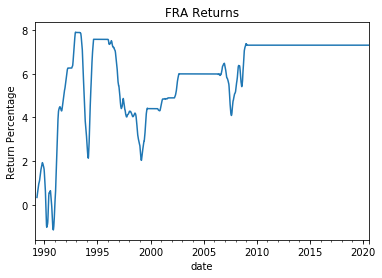

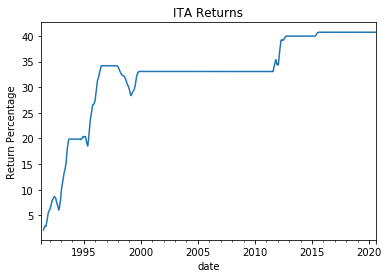

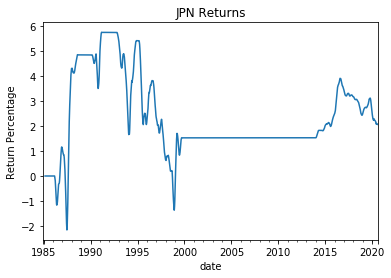

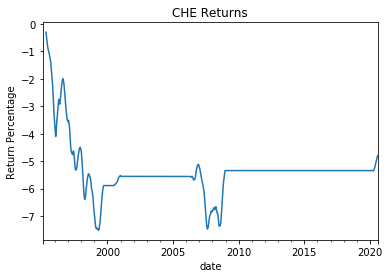

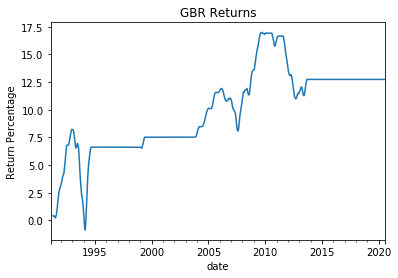

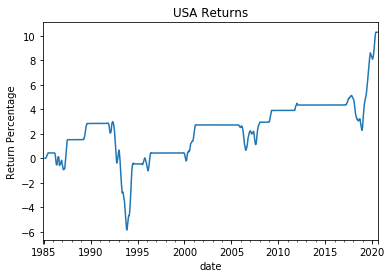

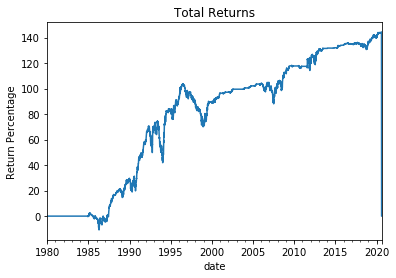

In [109]:
CH_signals = standardized_CH.divide(4).clip(-1,1)
CH_signals[np.abs(CH_signals) < .25] = 0
pnl_curve(CH_signals)

In [110]:
sharpe_ratio(CH_signals)

country
AUS        0.237361
DEU        0.152467
CAN        0.304840
ESP        0.483864
FRA        0.169581
ITA        0.579253
JPN        0.051852
CHE       -0.171341
GBR        0.291086
USA        0.191912
OVERALL    0.550169
dtype: float64

# Change in GDP

In [40]:
RGDP = dl.pull("GDP/Real")
RGDP_QOQ = RGDP.pct_change()
RGDP_QOQ.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2019Q3,0.005546,0.003093,0.002792,0.004047,0.001579,0.000052,0.000038,0.004400,0.005116,0.006369
2019Q4,0.005209,-0.000187,0.001397,0.004104,-0.001856,-0.002286,-0.018566,0.003379,-0.000001,0.005862
2020Q1,-0.003060,-0.020186,-0.021089,-0.052090,-0.059396,-0.053805,-0.005586,-0.026071,-0.021872,-0.012627
2020Q2,0.000000,-0.100915,0.000000,-0.184840,-0.138151,-0.123579,0.000000,0.000000,0.000000,-0.094947
2020Q3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [41]:
global_avg_1Y = RGDP_QOQ.rolling(4).mean().mean(axis=1)

# how is it doing relative to the global avg over the past year?
relative_growth = (RGDP_QOQ.sub(global_avg_1Y, axis=0))

# how does that relative performance compare to the country's relative performance
# over the past 6 years?
standardized_rel_growth = (relative_growth.rolling(24).
                           mean()-relative_growth)/relative_growth.rolling(24).std()

standardized_rel_growth.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2019Q3,-0.162717,0.020193,0.206482,0.592392,0.427115,0.454541,0.178985,-0.266310,-0.587815,-0.354600
2019Q4,-0.390337,0.563263,0.261830,0.320589,1.250388,1.210953,2.367752,-0.183993,1.141713,-0.470302
2020Q1,-0.345125,2.662708,2.712163,4.579798,4.548078,4.585810,-0.414715,3.698291,3.833893,2.685574
2020Q2,-3.998989,4.475454,-3.088173,4.486879,4.224126,4.224901,-2.958562,-3.132933,-3.566540,4.614701
2020Q3,-3.039866,-1.514345,-2.608964,-0.815700,-1.137121,-1.325946,-2.484606,-2.616152,-2.836033,-1.507105


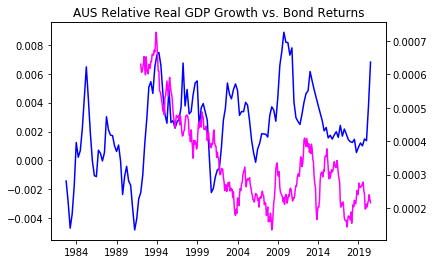

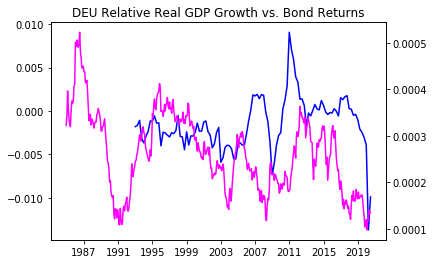

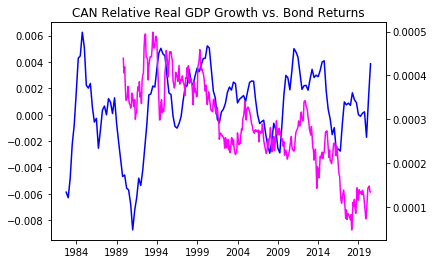

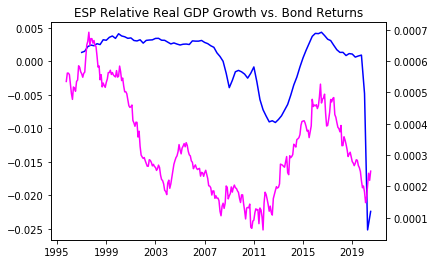

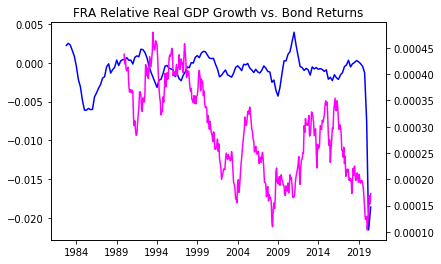

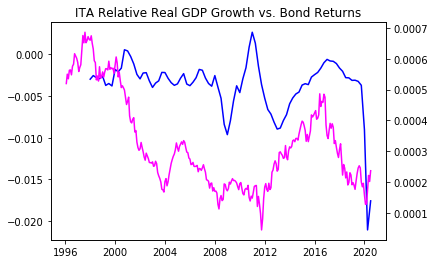

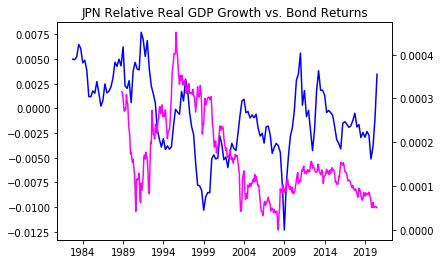

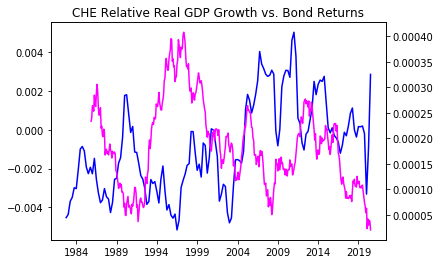

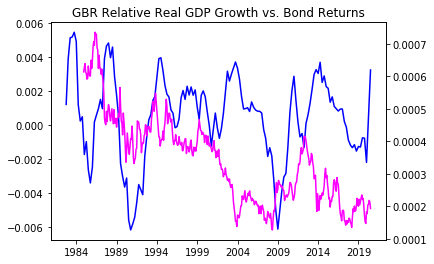

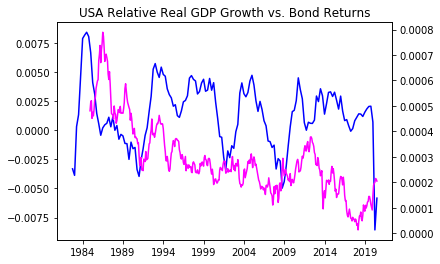

In [42]:
plot_vs_returns(relative_growth, 'Relative Real GDP Growth', 8)

In [53]:
GDP_signals = standardized_rel_growth.divide(2).clip(-1,1)
GDP_signals.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2019Q3,-0.081359,0.010096,0.103241,0.296196,0.213557,0.227270,0.089493,-0.133155,-0.293908,-0.177300
2019Q4,-0.195168,0.281631,0.130915,0.160295,0.625194,0.605477,1.000000,-0.091997,0.570857,-0.235151
2020Q1,-0.172563,1.000000,1.000000,1.000000,1.000000,1.000000,-0.207357,1.000000,1.000000,1.000000
2020Q2,-1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,1.000000
2020Q3,-1.000000,-0.757172,-1.000000,-0.407850,-0.568560,-0.662973,-1.000000,-1.000000,-1.000000,-0.753552


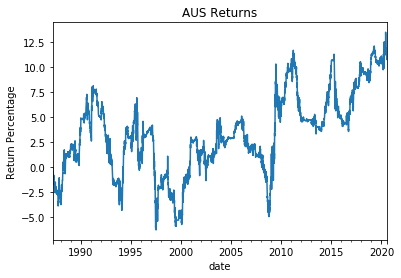

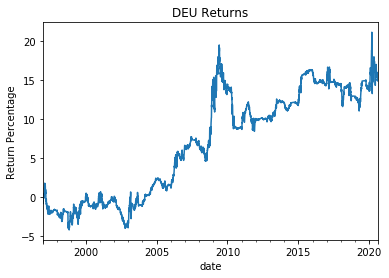

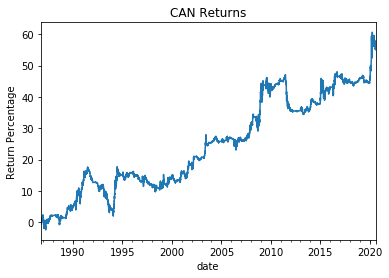

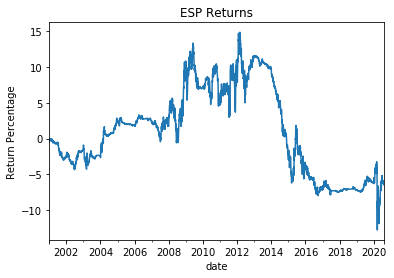

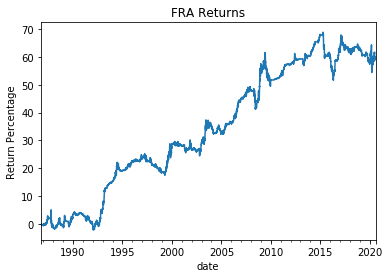

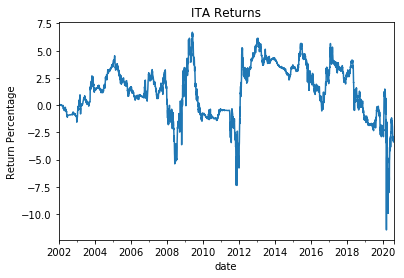

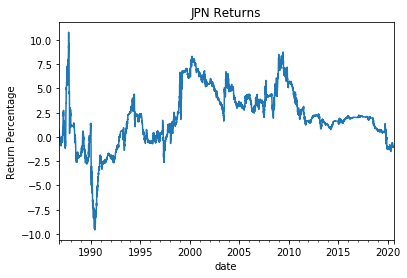

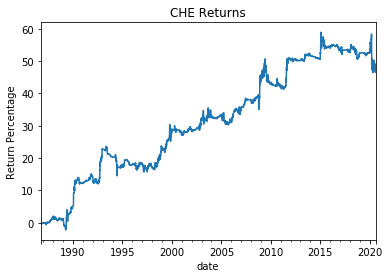

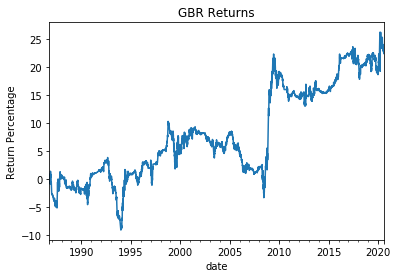

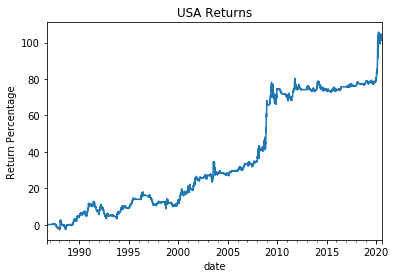

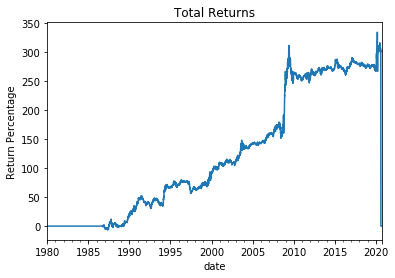

In [47]:
pnl_curve(GDP_signals)

In [48]:
sharpe_ratio(GDP_signals)

country
AUS        0.090024
DEU        0.226278
CAN        0.398929
ESP       -0.081017
FRA        0.473528
ITA       -0.043301
JPN       -0.013095
CHE        0.435721
GBR        0.194310
USA        0.560692
OVERALL    0.439576
dtype: float64

In [74]:
GDP_signals = standardized_rel_growth.divide(2).clip(-1,1)
GDP_signals[np.abs(GDP_signals) < .5] = 0

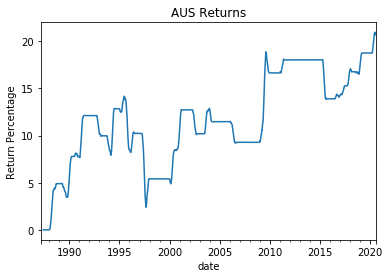

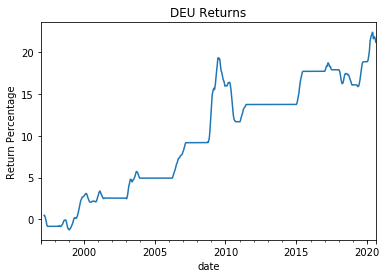

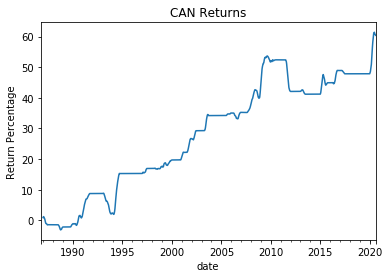

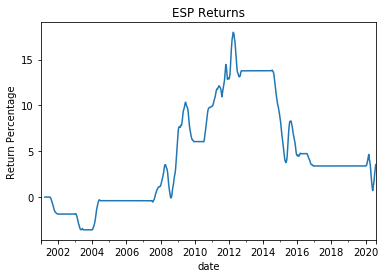

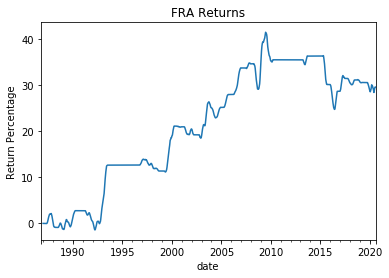

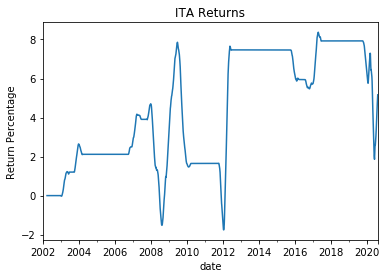

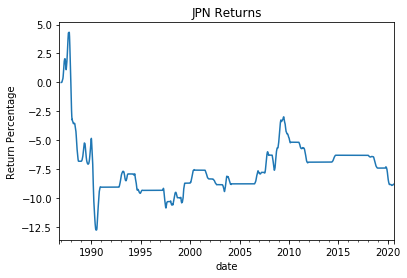

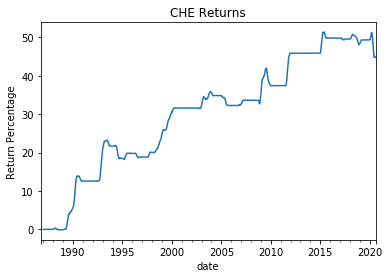

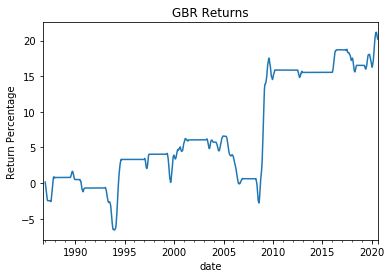

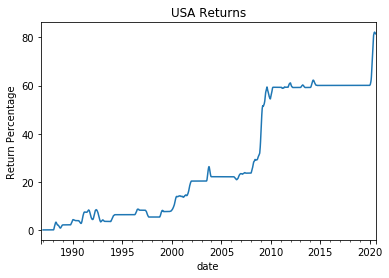

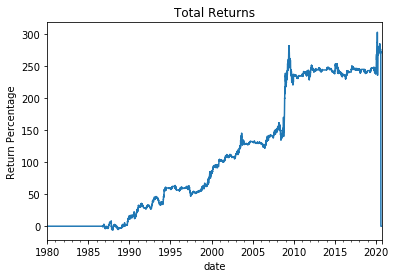

In [78]:
pnl_curve(GDP_signals)

In [79]:
sharpe_ratio(GDP_signals)

country
AUS        0.188145
DEU        0.322875
CAN        0.456006
ESP        0.049980
FRA        0.283197
ITA        0.061147
JPN       -0.125106
CHE        0.434817
GBR        0.189935
USA        0.511266
OVERALL    0.452464
dtype: float64

In [80]:
GDP_signals['JPN'] = GDP_signals['JPN']*-1

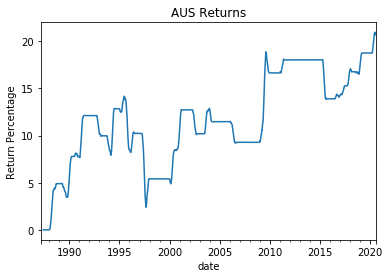

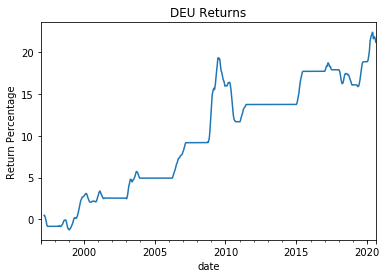

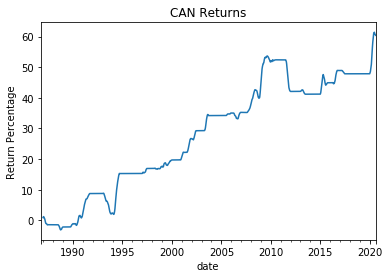

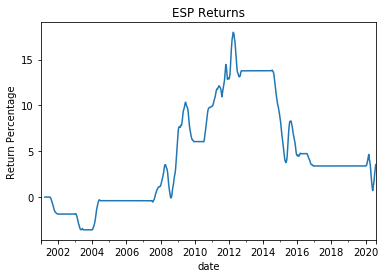

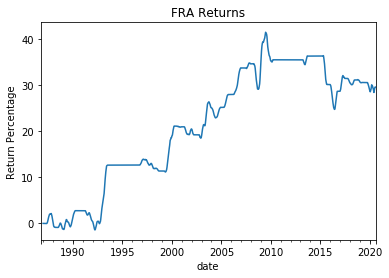

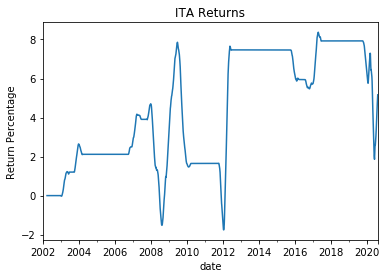

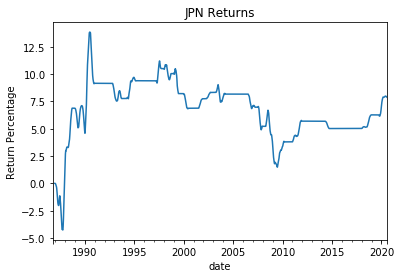

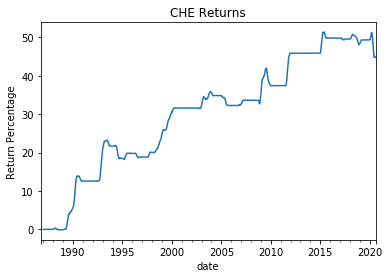

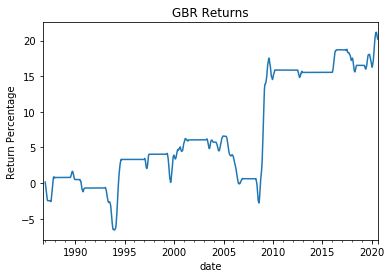

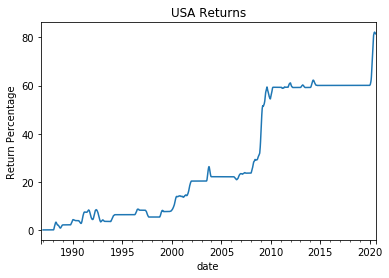

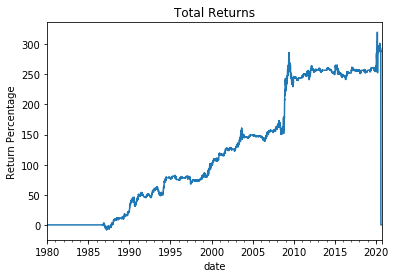

In [81]:
pnl_curve(GDP_signals)

In [82]:
sharpe_ratio(GDP_signals)

country
AUS        0.188145
DEU        0.322875
CAN        0.456006
ESP        0.049980
FRA        0.283197
ITA        0.061147
JPN        0.103474
CHE        0.434817
GBR        0.189935
USA        0.511266
OVERALL    0.498066
dtype: float64

# Combining Indicators

In [111]:
GDP_signals = GDP_signals.resample('M').ffill()

In [112]:
signals = pd.DataFrame(0, index=GDP_signals.index, columns=GDP_signals.columns)

**Naive Combination**

In [120]:
signals = .5*GDP_signals + .5*CH_signals

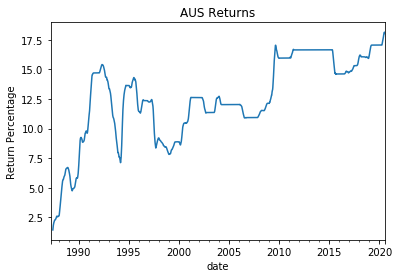

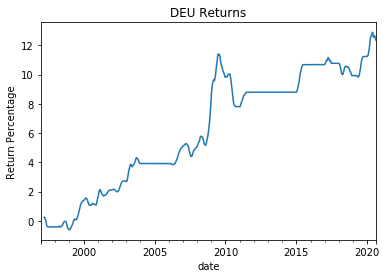

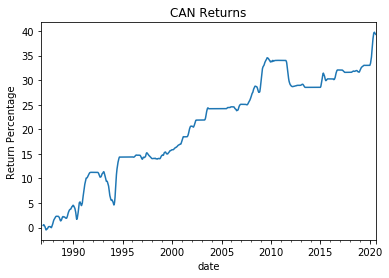

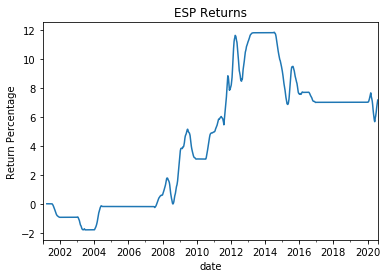

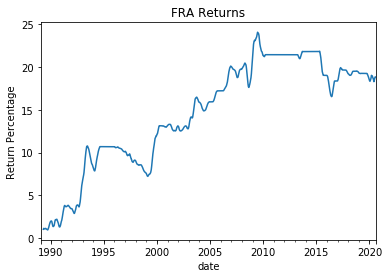

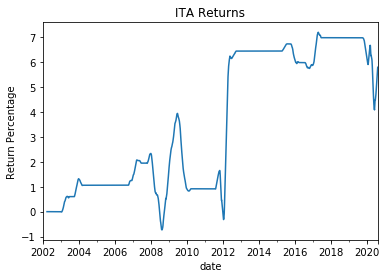

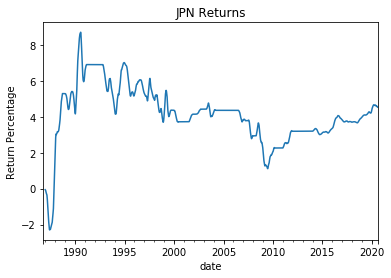

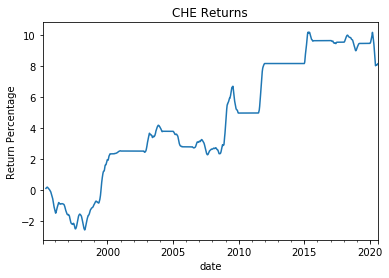

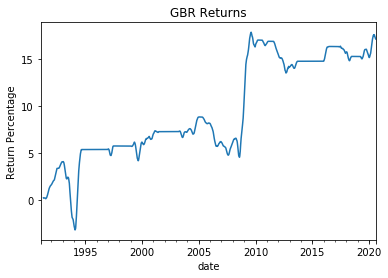

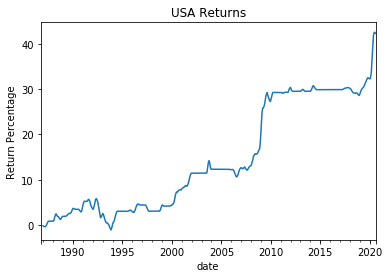

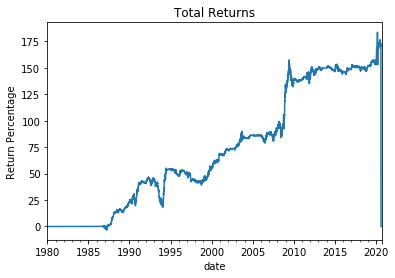

In [121]:
pnl_curve(signals)

In [122]:
sharpe_ratio(signals)

country
AUS        0.276135
DEU        0.372802
CAN        0.488048
ESP        0.156118
FRA        0.362895
ITA        0.129462
JPN        0.105734
CHE        0.238574
GBR        0.299038
USA        0.529582
OVERALL    0.549975
dtype: float64